# Quantitative Spatial Economics 

## Tutorial Topic 2: Monocentric City Model

Humboldt University Berlin & Berlin School of Economics

Authors:
[Dominik Bursy](mailto:dominik.bursy@icloud.com),
[Lars Felder](),
[Marlon Krippendorf]()

Last Update: May 2024

---

In Topic 2,we covered the monocentric city model in the lecture. In this tutorial, we test for the central prediction of the model, i.e. that bid-rents fall in distance from the central business district.

Start by cloning the repository [AHS2023-toolkit](#https://github.com/Ahlfeldt/AHS2023-toolkit/).


---

## Table of Contents

- [Import Packages](#packages)
- [Import Datasets](#data_import)
- [1. Average Wage](#average_wage)
- [2. House Price Index](#house_price_index)
- [3. Exogenous Factors](#exogenous_factors)
- [Appendix](#appendix)

## Import Packages <a class="anchor" id="packages"></a>

In [1]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import geopandas as gpd
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from linearmodels import PanelOLS 
# from tabulate import tabulate

import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

## Document Options
savefigures = False
# pd.set_option('display.max_columns', None)

In [2]:
## Set Root Directory
ROOT_FOLDER = str(Path().absolute().parent)
print(ROOT_FOLDER)

/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration


## Import and Data Preparation <a class="anchor" id="data_import"></a>

In [3]:
## Create Output Directory
OUTPUT_FOLDER = f'{ROOT_FOLDER}/data/ahs_index'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
# os.rmdir(OUTPUT_FOLDER)

### Data Import 1: German Cities

In [4]:
## Load shapefile of German postal codes 
gdf_zip_codes = gpd.read_file(f'{ROOT_FOLDER}/data/Shapefiles-2022/Germany/POSTCODES/postcode_clean_final.shp')

In [5]:
## Load data on German cities on postal code level 
url = 'https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-germany-postleitzahl/exports/csv?lang=en&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B'
df_cities = pd.read_csv(url, delimiter=';')

## Alternatively, load georeferenced German cities on postal code level 
# url = 'https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-germany-postleitzahl/exports/shp?lang=en&timezone=Europe%2FBerlin'
# df_cities = gpd.read_file(url)

In [6]:
## Subset to largest German cities: Berlin, Hamburg, Munich, Cologne, Frankfurt
condition_berlin = (df_cities['Kreis name'] == 'Kreisfreie Stadt Berlin')
condition_hamburg = (df_cities['Kreis name'] == 'Kreisfreie Stadt Hamburg')
condition_munich = (df_cities['PLZ Name (short)'] == 'München') ## Excludes Haar
condition_cologne = (df_cities['PLZ Name (short)'] == 'Köln') ## Excludes Gladbach
condition_frankfurt = (df_cities['Kreis name'] == 'Kreisfreie Stadt Frankfurt am Main')
# condition_frankfurt = ((df_cities['Kreis name'] == 'Kreisfreie Stadt München').astype(int) - (df_cities['PLZ Name (short)'] == 'München').astype(int)) == 1
condition_cities = [condition_berlin, condition_hamburg, condition_munich, condition_cologne, condition_frankfurt]

## Encode cities and create indicators
cities = ['berlin', 'hamburg', 'munich', 'cologne', 'frankfurt']
for index, city in enumerate(cities):
    df_cities.loc[condition_cities[index], city] = 1
    df_cities.loc[condition_cities[index], 'city'] = city
df_cities[cities] = df_cities[cities].fillna(value=0)

## Rename columns
df_cities.rename(columns={'Name':'plz'}, inplace=True)

## Drop duplicates
df_cities.drop_duplicates(subset=['plz', 'city'], inplace=True)

In [7]:
## Add city information to postal code shapefile 
gdf_zip_codes = gdf_zip_codes.set_index('ZIP').join(
    df_cities[cities + ['city', 'plz']].set_index('plz'), validate='1:m').dropna(subset=['city']).reset_index()

In [8]:
## Calculate the geographic center of each postalcode
#gdf_zip_codes['shape_center_x'] = gdf_zip_codes.centroid.x
#gdf_zip_codes['shape_center_y'] = gdf_zip_codes.centroid.y

## Rename columns and subset dataframe
gdf_zip_codes.rename(columns={'index':'target_id', 'INSIDE_X':'target_x', 'INSIDE_Y': 'target_y',
                              'OBJECTID': 'shape_id', 'Shape_Leng':'shape_length', 'Shape_Area':'shape_area', 
                              }, inplace=True)
gdf_zip_codes = gdf_zip_codes[['target_id', 'target_x', 'target_y', 'shape_id', 'shape_length', 'shape_area', #'shape_center_x', 'shape_center_y', 
                               'city', 'berlin', 'hamburg', 'munich', 'cologne', 'frankfurt', 'geometry']]

In [9]:
## Export dataframe
gdf_zip_codes.drop(columns=['geometry']).to_stata(f'{OUTPUT_FOLDER}/centroids.dta') 
# gdf_zip_codes.loc[gdf_zip_codes['city'] == 'berlin'].drop(columns=['geometry']).to_stata(f'{OUTPUT_FOLDER}/centroids.dta') 

### Data Import 2: Transactions Panel

In [10]:
## Load dataframes on housing market transcations
df_hk = pd.read_stata(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/panel/CampusFile_HK_cities.dta')
df_wk = pd.read_stata(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/panel/CampusFile_WK_cities.dta')
df_wm = pd.read_stata(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/panel/CampusFile_WM_cities.dta')

In [11]:
## Define transaction type: Kaufen vs Mieten
df_hk['type'] = 0
df_wk['type'] = 0
df_wm['type'] = 1

## Concatinate dataframes 
df_transactions = pd.concat([df_hk, df_wk, df_wm], axis=0)

## Drop duplicates
df_transactions.drop_duplicates(inplace=True)

## Drop missing postal codes
df_transactions = df_transactions.loc[pd.to_numeric(df_transactions['plz'], errors='coerce').notna()]
df_transactions['plz'] = df_transactions['plz'].astype(int)

In [12]:
## Merge with cities 
gdf_transactions = gdf_zip_codes.set_index('target_id').join(df_transactions.set_index('plz'), validate='1:m')

## Add x-y coordinate (in ETRS) projections
df_georeference = pd.read_stata(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/_grid_georeferences/grid.coordinaten_xy.dta')
gdf_transactions = gdf_transactions.set_index('ergg_1km').join(df_georeference.set_index('ergg_1km'), validate='m:1').reset_index()

## Drop missing values
gdf_transactions.dropna(subset=['origin_X', 'origin_Y'], inplace=True)

### Data Preparation

In [13]:
## lprice_qm and year
gdf_transactions.loc[gdf_transactions['type'] == 0, 'lprice_qm'] = np.log(gdf_transactions.loc[gdf_transactions['type'] == 0, 'price_sqm'])
gdf_transactions.loc[gdf_transactions['type'] == 1, 'lprice_qm'] = np.log(gdf_transactions.loc[gdf_transactions['type'] == 1, 'rent_sqm'])
gdf_transactions['year'] = gdf_transactions['edat'].dt.year

## Hedonic characteristics
gdf_transactions['age'] = 2022 - gdf_transactions['baujahr']
gdf_transactions.loc[gdf_transactions['etage'] == 'Other missing', 'etage'] = np.nan
gdf_transactions.loc[gdf_transactions['etage'] == 'Implausible value', 'etage'] = np.nan
gdf_transactions.loc[gdf_transactions['zimmeranzahl'] == 'Implausible value', 'zimmeranzahl'] = np.nan

## Demeaning of hedonic characteristics
for var in ['age', 'etage', 'zimmeranzahl', 'wohnflaeche']:
    #mean_val = gdf_transactions[var].mean()
    gdf_transactions[f'Att_{var}'] = gdf_transactions[var] #- mean_val
gdf_transactions['city'] = gdf_transactions['city'].astype('category')
gdf_transactions['Att_etage'] = gdf_transactions['Att_etage'].astype(float)
gdf_transactions['Att_zimmeranzahl'] = gdf_transactions['Att_zimmeranzahl'].astype(float)

In [14]:
## Rename columns and subset dataframe and drop duplicates
gdf_transactions.rename(columns={'obid':'transactions_id', 'city':'submarketid'}, inplace=True)
gdf_transactions = gdf_transactions[[
    'transactions_id', 'lprice_qm', 'year', 'Att_age', 'Att_etage', 'Att_zimmeranzahl', 'Att_wohnflaeche', 'submarketid', 'origin_X', 'origin_Y', 'type', 'geometry'
]].drop_duplicates()

In [15]:
## Export dataframe
gdf_transactions.loc[gdf_transactions['type'] == 0].drop(columns=['geometry']).to_stata(f'{OUTPUT_FOLDER}/transactions_purchase.dta') 
gdf_transactions.loc[gdf_transactions['type'] == 1].drop(columns=['geometry']).to_stata(f'{OUTPUT_FOLDER}/transactions_rent.dta') 

In [16]:
## Export dataframe
# gdf_transactions.loc[(gdf_transactions['type'] == 0) & (gdf_transactions['submarketid'] == 'berlin')].drop(columns=['geometry']).to_stata(f'{ROOT_FOLDER}/transactions_purchase.dta') 
# gdf_transactions.loc[(gdf_transactions['type'] == 1) & (gdf_transactions['submarketid'] == 'berlin')].drop(columns=['geometry']).to_stata(f'{ROOT_FOLDER}/transactions_rent.dta') 

### Create House Price Indices 

In [17]:
# Setup Stata
import stata_setup
stata_setup.config("/Applications/Stata", "se", splash=True)


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      StataNow 18.5
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2023 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-782-8272        https://www.stata.com
                                   979-696-4600        service@stata.com

Stata license: Unlimited-user network, expiring 13 Oct 2025
Serial number: 401809306098
  Licensed to: Dominik Bursy
               Freie Universität Berlin

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.


In [18]:
%%stata
cd ..
pwd


. cd ..
/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration

. pwd
/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration

. 


In [36]:
%%stata
use "data/ahs_index/centroids.dta", clear
global transaction_dataset "data/ahs_index/transactions_purchase.dta"
do "notebooks/_USE_PREDICT.do"
save "data/ahs_index/AHS_Index_purchase.dta", replace


. pwd
/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration

. use "data/ahs_index/centroids.dta", clear

. global transaction_dataset "data/ahs_index/transactions_purchase.dta"

. do "notebooks/_USE_PREDICT.do"

. // This do file generates an rental price index for 1km Hexagons for the Berl
> in rental market.
. // By Gabriel M Ahlfeldt 2021
. // For Stata 16
. 
. 
. 
. * Set temporary woring directory
. global WD "data/ahs_index/ahs_temporary" // Name of temporary directory

. 
. 
. * Create temporary working direktory
. capture shell rmdir "$WD" /s /q

. mkdir $WD

. 
. // FULL RUN
. 
. * 0) LOAD PROGRAM
.         capture drop program PREDICT // Drop program if already loaded

.         do "resources/AHS2023-toolkit-main/DOS/_AUX_PROG"

. *****************************************************************************
> ***
. * (C) Gabriel M. Ahlfeldt, LSE, CEPR 2020
. * For Stata 16.0
. *****************************************************************************
> ***

rmdir: /s: No such file or directory
rmdir: /q: No such file or directory


Iteration 1 of 447 completed, kernel radius = 5 km, using 34689 observations
Iteration 2 of 447 completed, kernel radius = 5 km, using 37806 observations
Iteration 3 of 447 completed, kernel radius = 5 km, using 38140 observations
Iteration 4 of 447 completed, kernel radius = 5 km, using 39122 observations
Iteration 5 of 447 completed, kernel radius = 5 km, using 38181 observations
Iteration 6 of 447 completed, kernel radius = 5 km, using 33614 observations
Iteration 7 of 447 completed, kernel radius = 5 km, using 23785 observations
Iteration 8 of 447 completed, kernel radius = 5 km, using 28605 observations
Iteration 9 of 447 completed, kernel radius = 5 km, using 34185 observations
Iteration 10 of 447 completed, kernel radius = 5 km, using 11466 observations
Iteration 11 of 447 completed, kernel radius = 5 km, using 16887 observations
Iteration 12 of 447 completed, kernel radius = 10 km, using 34888 observations
Iteration 13 of 447 completed, kernel radius = 5 km, using 11700 observa

rmdir: data/ahs_index/ahs_temporary: Directory not empty
rmdir: /s: No such file or directory
rmdir: /q: No such file or directory


In [42]:
%%stata
use "data/ahs_index/centroids.dta", clear
global transaction_dataset "data/ahs_index/transactions_rent.dta"
do "notebooks/_USE_PREDICT.do" 
save "data/ahs_index/AHS_Index_rent.dta", replace


. use "data/ahs_index/centroids.dta", clear

. global transaction_dataset "data/ahs_index/transactions_rent.dta"

. do "notebooks/_USE_PREDICT.do" 

. // This do file generates an rental price index for 1km Hexagons for the Berl
> in rental market.
. // By Gabriel M Ahlfeldt 2021
. // For Stata 16
. 
. 
. 
. * Set temporary woring directory
. global WD "data/ahs_index/ahs_temporary" // Name of temporary directory

. 
. 
. * Create temporary working direktory
. capture shell rmdir "$WD" /s /q



. mkdir $WD

. 
. // FULL RUN
. 
. * 0) LOAD PROGRAM
.         capture drop program PREDICT // Drop program if already loaded

.         do "resources/AHS2023-toolkit-main/DOS/_AUX_PROG"

. *****************************************************************************
> ***
. * (C) Gabriel M. Ahlfeldt, LSE, CEPR 2020
. * For Stata 16.0
. *****************************************************************************
> ***
. 
. // This program loads estimates a property price index for arbitrary coordina
> tes
. // in the target data set using property information in the origin data set
. // Origin and target coordinates must be in projected meter units
. 
. // PREDICT SYNTAX: PREDICT A B C D E F G H I J K L M N
.         * A n_id that starts the loop, usually 1
.         * B n_id that ends the loop, usually $N (global for max. n_id)
.         * C first year if index
.         * D last year of index
.         * E Spatial window: Search for observations within this distance thre
> shold in

rmdir: data/ahs_index/ahs_temporary: No such file or directory
rmdir: /s: No such file or directory
rmdir: /q: No such file or directory



. 
. // PREDICT SYNTAX: PREDICT A B C D E F G H I J K L M N
.         * A n_id that starts the loop, usually 1
.         * B n_id that ends the loop, usually $N (global for max. n_id)
.         * C first year if index
.         * D last year of index
.         * E Search for observations within this distance threshold in km firs
> t, e.g. 10 
.         * F If not enough obs within E km, switch to F, e.g. 25
.         * G If not enough obs within F km, switch to G, e.g. 50
.         * H If stil not enough obs, switch to H, 100
.         * I Defines the number of obs in the above decision rule. e.g. 20000
.         * J searches for observations within this distance in km for spatial 
> fixed effect, e.g. 2.5
.         * K If not enough obs within E km, switch to F, e.g. 5
.         * L If not enough obs within E km, switch to F, e.g. 10
.         * M If not enough obs within E km, switch to F, e.g. 20
.         * N Defines the number of obs in the above spatial fixed effect decis
> ion 

In [43]:
## Remove temporary files
os.remove(f'{OUTPUT_FOLDER}/AHS-Index.csv')
os.remove(f'{OUTPUT_FOLDER}/AHS-Index.dta')

---

## Task 2: Vizualization (Map the index)

In [52]:
gdf_purchase_index = gdf_zip_codes.set_index('shape_id').join(pd.read_stata(f'{OUTPUT_FOLDER}/AHS_Index_purchase.dta').set_index('shape_id'))
gdf_rent_index = gdf_zip_codes.set_index('shape_id').join(pd.read_stata(f'{OUTPUT_FOLDER}/AHS_Index_rent.dta').set_index('shape_id'))

In [53]:
gdf_purchase_index['dlprice_qm'] = gdf_purchase_index['price_qm2022'] - gdf_purchase_index['price_qm2007']
gdf_rent_index['dlprice_qm'] = gdf_rent_index['price_qm2021'] - gdf_rent_index['price_qm2007']

In [54]:
## Shapefile Stadtbezirke Berlin
# https://daten.odis-berlin.de/de/dataset/bezirksgrenzen/
gdf_berlin = gpd.read_file('https://tsb-opendata.s3.eu-central-1.amazonaws.com/bezirksgrenzen/bezirksgrenzen.geojson')
gdf_berlin.to_crs('25832', inplace=True)

## Shapefile Stadtbezirke Munich
# https://opendata.muenchen.de/dataset?res_format=WMS
# gdf_munich = gpd.read_file('https://geoportal.muenchen.de/geoserver/gsm_wfs/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=gsm_wfs:vablock_stadtbezirke_opendata&outputFormat=application/json')

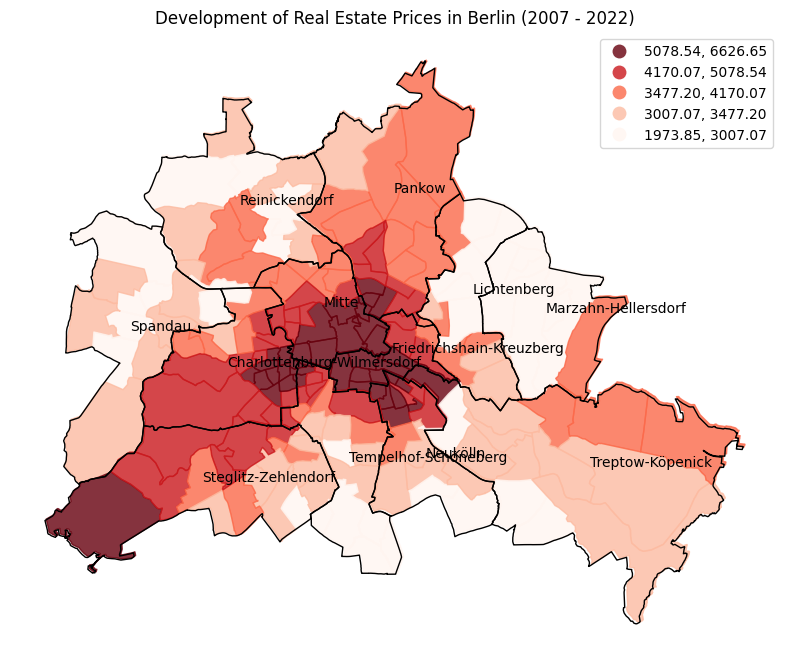

In [58]:
figure, axis = plt.subplots(1, 1, figsize=(8, 8)) 

gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin'].plot(column='dlprice_qm', cmap='Reds', edgecolor='face', ax=axis, alpha=0.8,
                                                                    # legend=True, legend_kwds={'orientation':'horizontal', "pad": 0})
                                                                    legend=True, scheme="quantiles", legend_kwds=dict(loc='upper right', reverse=True, ncol=1))

gdf_berlin.plot(facecolor='none', edgecolor='black', linewidth=1, ax=axis)

for x, y, label in zip(gdf_berlin.centroid.x, gdf_berlin.centroid.y, gdf_berlin.Gemeinde_name):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Development of Real Estate Prices in Berlin (2007 - 2022)')

handles, labels = axis.get_legend_handles_labels()

plt.tight_layout()

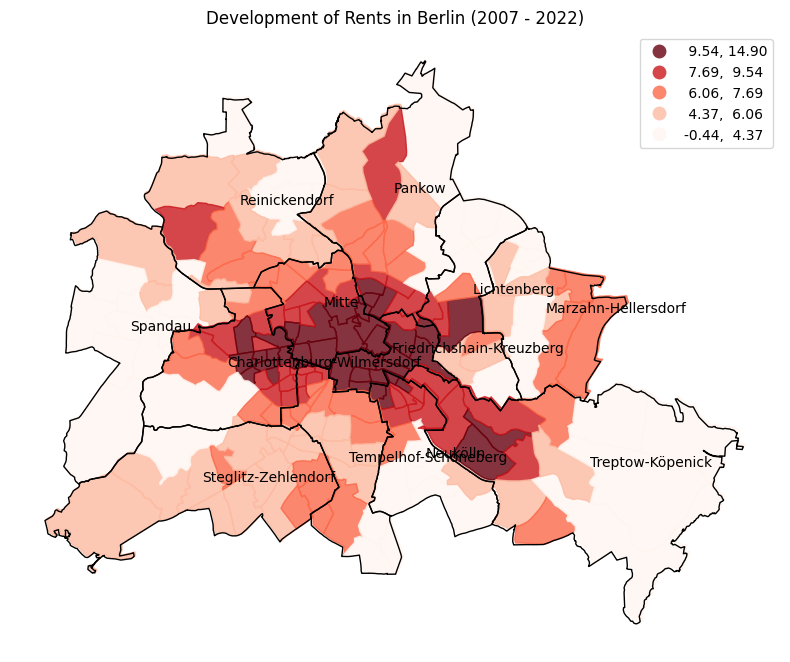

In [59]:
figure, axis = plt.subplots(1, 1, figsize=(8, 8)) 

gdf_rent_index.loc[gdf_rent_index['city'] == 'berlin'].plot(column='dlprice_qm', cmap='Reds', edgecolor='face', ax=axis, alpha=0.8,
                                                                    # legend=True, legend_kwds={'orientation':'horizontal', "pad": 0})
                                                                    legend=True, scheme="quantiles", legend_kwds=dict(loc='upper right', reverse=True, ncol=1))

gdf_berlin.plot(facecolor='none', edgecolor='black', linewidth=1, ax=axis)

for x, y, label in zip(gdf_berlin.centroid.x, gdf_berlin.centroid.y, gdf_berlin.Gemeinde_name):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Development of Rents in Berlin (2007 - 2022)')

handles, labels = axis.get_legend_handles_labels()

plt.tight_layout()

---

## Task 3: Price gradient

[https://github.com/Ahlfeldt/AABPL-toolkit-python?tab=readme-ov-file](#https://github.com/Ahlfeldt/AABPL-toolkit-python?tab=readme-ov-file)

In [ ]:
# gdf_rent_index.loc[gdf_rent_index['city'] == 'berlin'].sjoin(gpd.read_file('/Users/dominik.bursy/Downloads/shape_11/PL_11.shp').to_crs(gdf_rent_index.loc[gdf_rent_index['city'] == 'berlin'].crs))

In [ ]:
## Berlin CBD: 10117
## Munich CBD: 80331

---

## Appendix <a class="anchor" id="appendix"></a>

In [ ]:
## CODE HERE

## References

- [GitHub AHS2023-toolkit](#https://github.com/Ahlfeldt/AHS2023-toolkit/tree/main/APPLICATIONS/DATA/OUTPUT)
- ...
- ...

---